### Dataset 

https://www.kaggle.com/pariza/bbc-news-summary

# Data Set - Find and Format

The dataset used in this project is the buissness section of [BBC News Summary](https://www.kaggle.com/pariza/bbc-news-summary)

In [1]:
import os
import pandas as pd

import spacy
nlp = spacy.load("en_core_web_sm") #Why spacy over nltk? Nltk Tokenisation depends on 

/home/enfageorge/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-03-09 22:17:36.813187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-09 22:17:36.813204: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
articles_datapath = 'dataset/business_articles' 
summarises_datapath = 'dataset/business_summary'

article_names = [my_file for my_file in os.listdir(articles_datapath) if my_file.endswith(".txt")]

In [5]:
from nltk.tokenize import sent_tokenize

def formatText(article):
    doc = nlp(article)
    return list(filter(None,[str(sentence).replace("\n","") for sentence in doc.sents]))

In [6]:
dataset = {}
for article_name in article_names:
    with open(articles_datapath+"/"+article_name) as f:
        article = formatText(f.read())
    with open(summarises_datapath+"/"+article_name) as f:
        summary = formatText(f.read())
        
    dataset[article_name] ={"Article":article,
                          "Targetsummary":summary}

In [7]:
dataset_df= pd.DataFrame(dataset).T
dataset_df.sample(2)

,Article,Targetsummary
474.txt,[Virgin Blue shares plummet 20%Shares in Austr...,[Shares in Australian budget airline Virgin Bl...
033.txt,[Rich grab half Colombia poor fundHalf of the ...,[A total of 24.2 trillion pesos ($10.2bn; £5.5...


In [8]:
sent_tokenize(dataset_df['Targetsummary'][0][0])

['Yukos will return to a US court on Wednesday to seek sanctions against Baikal Finance Group, the little-known firm which has bought its main asset.']

# Cleaning and Formating the DataSet

In [9]:
import re

In [10]:
articles = dataset_df['Article'].to_list()
articles[0]

['Yukos seeks court action on saleYukos will return to a US court on Wednesday to seek sanctions against Baikal Finance Group, the little-known firm which has bought its main asset.',
 'Yukos has said it will sue Baikal and others involved in the sale of Yuganskneftegas for $20bn in damages.',
 "Yukos' US lawyers will attempt to have Baikal assets frozen after the Russian government ignored a US court order last week blocking the sale.",
 "Baikal's background and its motives for buying the unit are still unclear.",
 "Russian newspapers have claimed that Baikal - which bought the Yuganskneftegas production unit for $9.4bn (261bn roubles, £4.8bn) on Sunday at a state provoked auction - has strong links with Surgutneftegas, Russia's fourth-biggest oil producer.",
 "Many observers believe that the unit, which produces 60% of Yukos' oil output, could ultimately fall into the hands of Surgutneftegas or even Gazprom, the state gas firm which opted out of the auction.",
 "The Russian governmen

In [11]:
#Remove the special characters found in text - since they do not provide any relevent information to summarisation

pat = r"[^A-Za-z0-9 ]+" 
cleaned_text = [[re.sub(pat, '', sentence.lower()) for sentence in article] for article in articles]

In [12]:
cleaned_text[0]

['yukos seeks court action on saleyukos will return to a us court on wednesday to seek sanctions against baikal finance group the littleknown firm which has bought its main asset',
 'yukos has said it will sue baikal and others involved in the sale of yuganskneftegas for 20bn in damages',
 'yukos us lawyers will attempt to have baikal assets frozen after the russian government ignored a us court order last week blocking the sale',
 'baikals background and its motives for buying the unit are still unclear',
 'russian newspapers have claimed that baikal  which bought the yuganskneftegas production unit for 94bn 261bn roubles 48bn on sunday at a state provoked auction  has strong links with surgutneftegas russias fourthbiggest oil producer',
 'many observers believe that the unit which produces 60 of yukos oil output could ultimately fall into the hands of surgutneftegas or even gazprom the state gas firm which opted out of the auction',
 'the russian government forced the sale of yukos m

### Vectorisation of Text
`Tool of Choice - Glove Embeddings`

https://nlp.stanford.edu/projects/glove/

In [13]:
import numpy as np

In [14]:
word_embeddings = {}

# read the word embeddings file ~820MB
f = open('glove.6B.300d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

# check the length
if (len(word_embeddings) == 400000):
    print("Glove Vector Loaded : Status => OK")

Glove Vector Loaded : Status => OK


There is no need to do all articles at once in Exploration Phase. So just one article is used here. Will group them together at the end.

In [15]:
article = cleaned_text[0]

In [16]:
sentence_vectors = [sum([word_embeddings.get(w, np.zeros((300,))) for w in sentence.split(" ")])/(len(sentence.split())+0.001)
                   for sentence in article]

### Compute how similar sentences are 
`Tool of Choice : Cosine Similarity`

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

sim_mat = np.zeros([len(article),len(article)])

for i in range(len(article)):
    for j in range(len(article)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,300), sentence_vectors[j].reshape(1,300))[0,0]

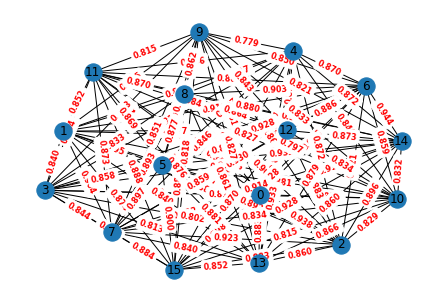

In [18]:
### Build a graph out of it

import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(sim_mat)
pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True)

edge_labels = dict([((n1, n2), '%.3f'%d['weight'])
                    for n1, n2, d in G.edges(data=True)])

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5,
                             font_color='red', font_size=8, font_weight='bold')

plt.show()

In [19]:
scores = nx.algorithms.pagerank_numpy(G)

/tmp/ipykernel_49231/3094204593.py:1: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  scores = nx.algorithms.pagerank_numpy(G)
/home/enfageorge/.local/lib/python3.8/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:354: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = google_matrix(


In [20]:
ranked_sentences = sorted(((scores[i],i) for i,s in enumerate(article)), reverse=True)

In [21]:
indexes = sorted([ranked_tuple[1] for ranked_tuple in ranked_sentences[:7]])
indexes

[0, 1, 2, 5, 6, 7, 14]

In [22]:
order_of_sen = [articles[0][index] for index in indexes]
order_of_sen

['Yukos seeks court action on saleYukos will return to a US court on Wednesday to seek sanctions against Baikal Finance Group, the little-known firm which has bought its main asset.',
 'Yukos has said it will sue Baikal and others involved in the sale of Yuganskneftegas for $20bn in damages.',
 "Yukos' US lawyers will attempt to have Baikal assets frozen after the Russian government ignored a US court order last week blocking the sale.",
 "Many observers believe that the unit, which produces 60% of Yukos' oil output, could ultimately fall into the hands of Surgutneftegas or even Gazprom, the state gas firm which opted out of the auction.",
 "The Russian government forced the sale of Yukos' most lucrative asset as part of its action to enforce a $27bn back tax bill it says the company owes.",
 "Yukos' US lawyers claim the auction was illegal because the firm had filed for bankruptcy and therefore its assets were now under the protection of US bankruptcy law which has worldwide jurisdict

In [23]:
dataset_df['Targetsummary'][0]

['Yukos will return to a US court on Wednesday to seek sanctions against Baikal Finance Group, the little-known firm which has bought its main asset.',
 'Yukos has said it will sue Baikal and others involved in the sale of Yuganskneftegas for $20bn in damages.',
 "Yukos' US lawyers will attempt to have Baikal assets frozen after the Russian government ignored a US court order last week blocking the sale.",
 "Yukos' US lawyers claim the auction was illegal because the firm had filed for bankruptcy and therefore its assets were now under the protection of US bankruptcy law which has worldwide jurisdiction.",
 'Yukos has claimed that the sale of its main asset will lead to the collapse of the company.',
 "Russian newspapers have claimed that Baikal - which bought the Yuganskneftegas production unit for $9.4bn (261bn roubles, £4.8bn) on Sunday at a state provoked auction - has strong links with Surgutneftegas, Russia's fourth-biggest oil producer.",
 "Many observers believe that the unit, 